In [261]:
import numpy as np
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
from bitalg.tests.test4 import Test
from bitalg.visualizer.main import Visualizer

In [262]:
def det_3x3(a, b, c):
    return (c[1]-b[1])*(b[0]-a[0])-(c[0]-b[0])*(b[1]-a[1])


def generate_uniform_points(left=-100, right=100, n=100, prec = 3):
    random.seed()
    points = set()
    for i in range(n):
        while True:
            x = round(random.uniform(left,right), prec)
            y = round(random.uniform(left,right), prec)
            new_point = (x,y)
            if new_point not in points:
                points.add(new_point)
                break
    return list(points)


def generate_rectangle_points(a=(-10, -10), b=(10, -10), c=(10, 10), d=(-10, 10), n=10**3):
    random.seed()
    points = set()
    edge = c[0]-a[0]
    for i in range (n):
        while True:
            dist=random.uniform(0,edge*4)
            if dist<edge:
                x=a[0]
                y=dist+a[1]
            elif dist<edge*2:
                x=dist-edge+d[0]
                y=d[1]
            elif dist<edge*3:
                x=b[0]
                y=dist-(edge*2)+b[1]
            else:
                x=dist-(edge*3)+a[0]
                y=a[1]
            new_point = (x,y)
            if new_point not in points:
                points.add(new_point)
                break
    return list(points)


def zlacz(arr1, arr2):
    temp = []
    for i in range(len(arr1)):
        temp.append(arr1[i])
    for j in range(len(arr2)):
        temp.append(arr2[j])
    return temp


def merge(A, B, a, b):
    if(not len(A) or not len(B)):
        return zlacz(A, B)
    n, m, hull = len(A), len(B), []
    for i in range(a+1):
        hull.append(A[i])
    for j in range(b, m, 1):
        hull.append(B[j])
    return hull


def check(A, B, mid_a, mid_b, p = 1):
    n, m = len(A), len(B)
    if(mid_a >= 1 and det_3x3(A[mid_a], B[mid_b], A[mid_a - 1]) * p >= 0):
        return False
    if(mid_a <= n-2 and det_3x3(A[mid_a], B[mid_b], A[mid_a + 1]) * p >= 0):
        return False
    if(mid_b >= 1 and det_3x3(A[mid_a], B[mid_b], B[mid_b - 1]) * p >= 0):
        return False
    if(mid_b <= m-2 and det_3x3(A[mid_a], B[mid_b], B[mid_b + 1]) * p >= 0):
        return False
    return True


def upper_circle_points(O, R, n, k, prec):
    points=[]
    step = 1/n
    for i in range (n//k):
        t = step * i
        x = O[0] + round(R*np.cos(t*np.pi*2), prec)
        y = O[1] + round(R*np.sin(t*np.pi*2), prec)
        points.append((x,y))
    return points


def lower_circle_points(O, R, n, k, prec):
    points=[]
    step = 1/n
    for i in range (((k-1) * n)//k, n):
        t = step * i
        x = O[0] + round(R*np.cos(t*np.pi*2), prec)
        y = O[1] + round(R*np.sin(t*np.pi*2), prec)
        points.append((x,y))
    return points

def add_perimeter(hull, Visual, col):
    n = len(hull)
    for i in range(n-1):
        Visual.add_line_segment([(hull[i], hull[i+1])], color = col)
    Visual.add_line_segment([(hull[-1], hull[0])], color = col)
    return

def concat_arr(arr1, arr2):
    res = []
    for i in range(len(arr1)):
        res.append(arr1[i])
    m = len(arr2)
    start, end = 0, m-1
    if(arr2[0] == arr1[0]):
        start = 1
    if(arr2[-1] == arr2[-1]):
        end = m-2
    for j in range(end, start-1, -1):
        res.append(arr2[j])
    return res

def classify(hull):
    n = len(hull)
    A, B = hull[0], hull[-1]
    up, down = [A], [A]
    for i in range(1, n-1):
        orient = det_3x3(A, B, hull[i])
        if(orient > 0):
            up.append(hull[i])
        elif(orient < 0):
            down.append(hull[i])
    up.append(B)
    down.append(B)
    return up, down


def split(hull):
    n, ind = len(hull), -1
    for i in range(1, n, 1):
        if(hull[i-1] > hull[i]):
            ind = i-1
            break
    if(ind == -1):
        return hull, [hull[0], hull[-1]]
    l, r = hull[:(ind+1)], hull[(ind):]
    r.append(hull[0])
    r.reverse()
    return l, r

def BruteHull(points, Visual, col):
    n, hull = len(points), []
    vis = [0] * n
    for i in range(n):
        for j in range(i+1, n, 1):
            inside, outside = 0, 0
            for k in range(n):
                orient = det_3x3(points[i], points[j], points[k]) 
                if(k == j or k == i or orient == 0):
                    inside, outside = inside + 1, outside + 1
                elif(orient < 0):
                    outside += 1
                else:
                    inside += 1
            if(inside == n or outside == n):
                vis[i], vis[j] = 1, 1
                
    for i in range(n):
        if(vis[i]):
            hull.append(points[i])
    #Visual.add_point(hull, color = "grey")
    #Visual.show()
    #print("HULL:", hull)
    up, down = classify(hull)
    new_hull = concat_arr(up, down)
    return new_hull
        

In [263]:
def convert(points):
    new_points, n = [], len(points)
    for i in range(n):
        new_points.append((points[i], i))
    return new_points


def bin_search(A, B, p = 1):
    #print("parametr:", p)
    n, m = len(A), len(B)
    left_a, right_a, left_b, right_b, mid_a, mid_b = 0, n-1, 0, m-1, -1, -1
    mid_a = (left_a + right_a)//2
    while(True):
        left_b, right_b = 0, m-1
        while(True):
            mid_b, flag = (left_b + right_b)//2, True
            #print("B:", left_b, mid_b, right_b, "mid_a:", mid_a)
            if(left_b == right_b):
                break
            if(mid_b >= 1):
                #print("orient:", "mid_a:", mid_a, "mid_b:", mid_b, "mid_b-1:", mid_b - 1)
                orient = det_3x3(A[mid_a], B[mid_b], B[mid_b-1])
                #print(round(orient, 2))
                if(orient * p >= 0):
                    right_b, flag = mid_b-1, False
            if(mid_b <= m-2):
                #print("orient:", "mid_a:", mid_a, "mid_b:", mid_b, "mid_b+1:", mid_b + 1)
                orient = det_3x3(A[mid_a], B[mid_b], B[mid_b+1])
                #print(round(orient, 2))
                if(orient * p >= 0):
                    left_b, flag = mid_b+1, False
            if(flag):
                break
        left_a, right_a = 0, n-1
        while(True):
            mid_a, flag = (left_a + right_a)//2, True
            if(left_a == right_a):
                break
            #print("A:", left_a, mid_a, right_a, "mid_b:", mid_b)
            if(mid_a >= 1):
                #print("orient:", "mid_a:", mid_a, "mid_b:", mid_b, "mid_a-1", mid_a - 1)
                orient = det_3x3(A[mid_a], B[mid_b], A[mid_a - 1])
                #print(round(orient, 2))
                if(orient*p >= 0):
                    right_a, flag = mid_a-1, False
            if(mid_a <= n-2):
                #print("orient:", "mid_a:", mid_a, "mid_b:", mid_b, "mid_a+1:", mid_a + 1)
                orient = det_3x3(A[mid_a], B[mid_b], A[mid_a + 1])
                #print(round(orient, 2))
                if(orient*p >= 0):
                    left_a, flag = mid_a+1, False
            if(flag):
                break  
        #print("compare", mid_a, mid_b)    
        if(check(A, B, mid_a, mid_b, p)):
            #print("WYNIK:", mid_a, mid_b)
            return mid_a, mid_b
      

      

In [264]:
def Divide_Conquer(points, Visual, col):
    n = len(points)
    #print(n)
    if(n <= 6):
        hull = BruteHull(points, Visual, col)
        #print("n:", n)
        #print(hull)
        return hull
    mid, ind_a_up, ind_b_up, ind_a_down, ind_b_down = n//2, -1, -1, -1, -1
    
    A = Divide_Conquer(points[0:mid], Visual, col)
    B = Divide_Conquer(points[mid:], Visual, col)
    
    A_up, A_down = split(A)
    B_up, B_down = split(B)
    
    
    if(len(A_up) and len(B_up)):
        ind_a_up, ind_b_up = bin_search(A_up, B_up)
    up_total = merge(A_up, B_up, ind_a_up, ind_b_up)
    #print("up total:", up_total)
    
    if(len(A_down) and len(B_down)):
        ind_a_down, ind_b_down = bin_search(A_down, B_down, -1)
    down_total = merge(A_down, B_down, ind_a_down, ind_b_down)
    #print("down_total:", down_total)
    
    res = concat_arr(up_total, down_total)
    return res
    

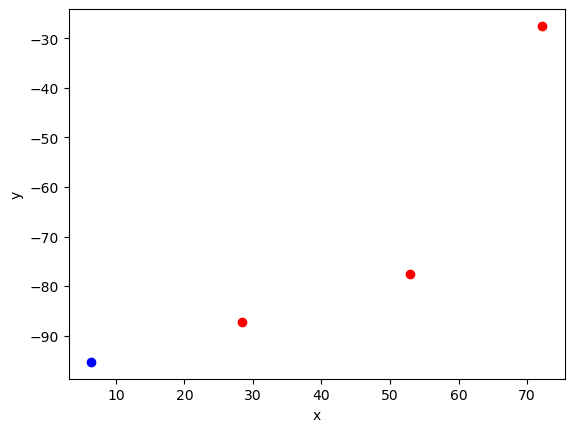

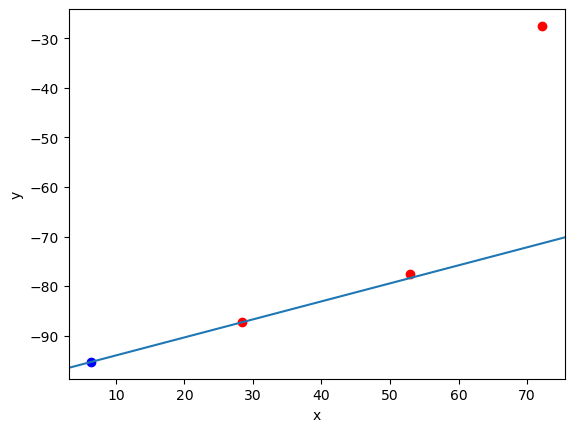

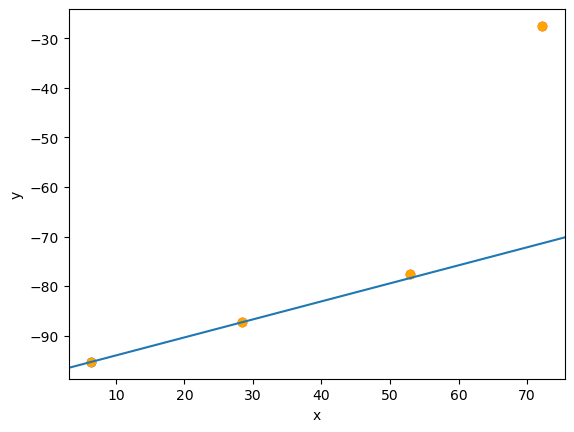

In [265]:
def testy_otoczki():
    penis = Visualizer()
    dupa1 =  [(6.4, -95.3)]
    dupa2 = [(72.2, -27.5), (52.9, -77.6), (28.4, -87.3)]
    dupa2.reverse()
    penis.add_point(dupa1, color = "blue")
    penis.add_point(dupa2, color = "red")
    penis.show()
    d1, d2 = bin_search(dupa1, dupa2, -1)
    penis.add_line([(dupa1[d1], dupa2[d2])])
    penis.show()
    dupsko = merge(dupa1, dupa2, d1, d2)
    penis.add_point(dupsko, color = "orange")
    penis.show()
testy_otoczki()

In [303]:


def prepare():
    vis8 = Visualizer()
    n = 10**3
    #test = [ (1,1),(1,2),(1,3),(1,4),(1,5),(2,1),(2,2),(2,3),(2,4),(2,5) ] 
    #test = [ (1,1),(1,2),(1,3),(1,4),(1,5),(1,6),(1,7),(1,8),(1,9),(2,1) ]
    #test = [ (1,1),(1,2),(1,3),(1,4),(1,5),(2,1),(3,2),(4,4),(5,7),(6,11) ]
    #test = [ (1,1),(1,2),(1,3),(1,4),(1,5),(1,6),(1,7),(1,8),(1,9),(1,10) ]
    #test = [ (1,1),(1,2),(1,3),(1,4),(1,5),(2,1),(3,2),(24,4),(5,7),(6,11) ]
    #test = [ (1,1),(1,2),(1,3),(1,4),(1,5),(2,1),(3,2),(24,14),(30,14),(6,11) ]
    #test = generate_rectangle_points(n = 100)
    test = generate_uniform_points(-100, 100, n, 2)
    #test = upper_circle_points((0, 0), 10**3, 10**4, 1, 6)
    print("JEBAC DISA")
    
    #test = [(-85.5, 55.0), (-55.4, -14.7), (-50.7, 55.5),
           #(-39.2, -4.9), (-8.8, 0.6), (8.0, 69.7), (20.5, 41.8), (56.2, -15.5), (82.4, -74.8), (87.5, -87.3)]
        
    #test = [(-94.4, -12.9), (-90.5, -4.2), (-70.4, 86.7), (-65.5, 75.7), (-4.4, -27.2), (19.6, 84.1),
            #(39.3, 77.2), (60.2, -63.0), (66.9, 74.9), (91.6, -32.6)]
        
    #test = [(0, 1), (0, 5), (0, 3), (3, 8), (6, -10), (7, -10), (8, -10), (8, -4), (9, -4), (9.5, -4), 
            #(10, -1), (15, 7), (15, 10), (15, 4)]
    
    test.sort()
    vis8.add_point(test, color = "blue")
    vis8.show()
    
    #left, right = test[:(n//2)], test[(n//2):]
    #left_hull = BruteHull(left, vis8, "green")
    #right_hull = BruteHull(right, vis8, "orange")
    #left_up, left_down = split(left_hull)
    #right_up, right_down = split(right_hull)
    
    """
    vis8.add_point(left_hull, color = "green")
    vis8.add_point(right_hull, color = "red")
    vis8.show()
    vis8.add_point(right_hull, color = "blue")
    vis8.add_point(left_up, color = "brown")
    vis8.add_point(left_down, color = "pink")
    vis8.show()
    vis8.add_point(left_hull, color = "green")
    
    vis8.add_point(right_up, color = "purple")
    vis8.add_point(right_down, color = "orange")
    vis8.show()
    vis8.add_point(left_up, color = "brown")
    vis8.add_point(left_down, color = "pink")
    vis8.show()
    vis8.add_point(left_hull, color = "green")
    up_total, down_total = [], []
    """
    
    
    X = """
    if(len(left_up) and len(right_up)):
        ind_up_l, ind_up_r = bin_search(left_up, right_up, 1)
    up_total = merge(left_up, right_up, ind_up_l, ind_up_r)
    
    
    if(len(left_down) and len(right_down)):
        ind_down_l, ind_down_r = bin_search(left_down, right_down, -1)
    down_total = merge(left_down, right_down, ind_down_l, ind_down_r)
    
    vis8.add_point(right_hull, color = "red")
    vis8.show()
    print()
    vis8.add_point(up_total, color = "purple")
    vis8.add_point(down_total, color = "orange")
    vis8.show()
    """
    
    Y =  """
    res = concat_arr(up_total, down_total)
    vis8.add_point(res, color = "cyan")
    vis8.show()
    add_perimeter(res, vis8, "cyan")
    vis8.show()
    
    #print("Punkty testowe:")
    #print(test)
    #print()
    """
    
    
    """
    print("LEFT:", left)
    print("Left_gorna:", left_up)
    print("Left_dolna:", left_down)
    print()
    print("RIGHT:", right)
    print("Right gorna:", right_up)
    print("Right dolna:", right_down)
    print()
    print("gorna total:", up_total)
    print("dolna total:", down_total)
    
    print("RES:", res)
    chuj1, chuj2 = split(res)
    print("chuj1:", chuj1)
    print("chuj2:", chuj2)
    """
    
    return test








In [304]:
def testuj(test):
    vis9 = Visualizer()
    vis9.add_point(test, color = "blue")
    result = Divide_Conquer(test, vis9, "orange")
    vis9.show()
    vis10 = Visualizer()
    vis10.add_point(test, color = "blue")
    vis10.add_point(result, color = "cyan")
    add_perimeter(result, vis10, "cyan")
    vis10.show()

JEBAC DISA


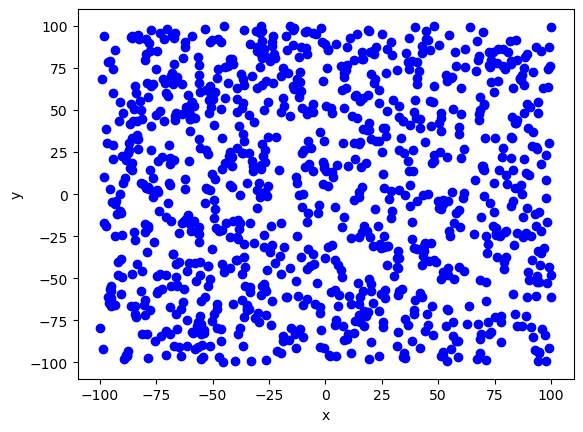

In [307]:
dane = prepare()

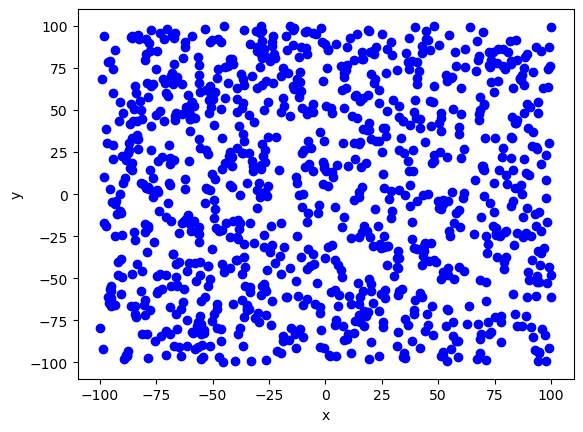

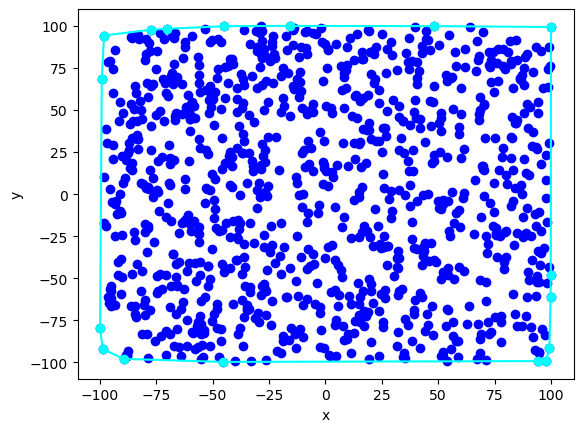

In [308]:
testuj(dane)

PIZDA NAD GLOWA


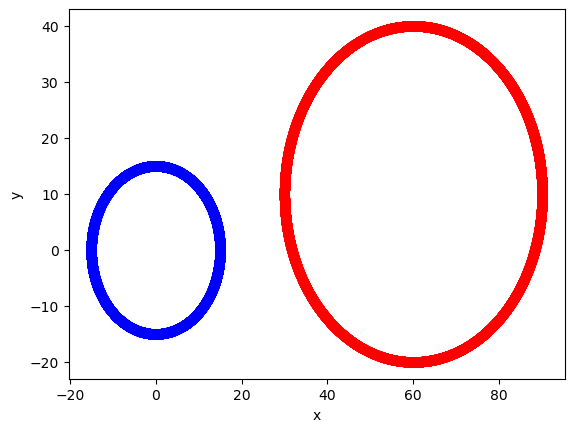

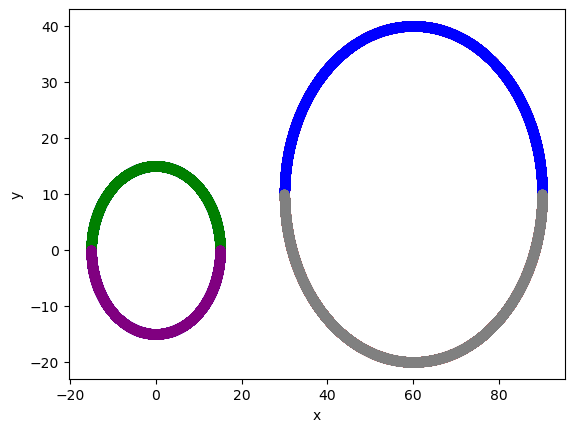

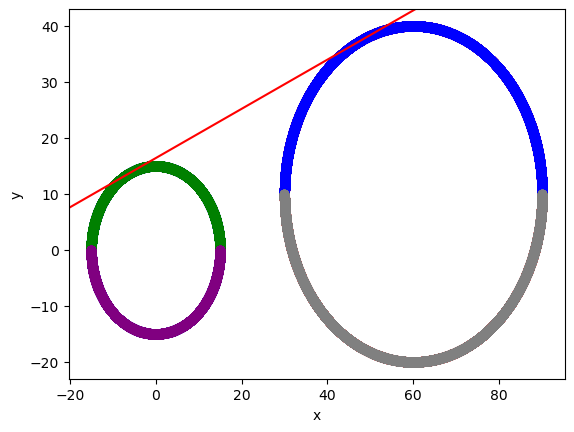

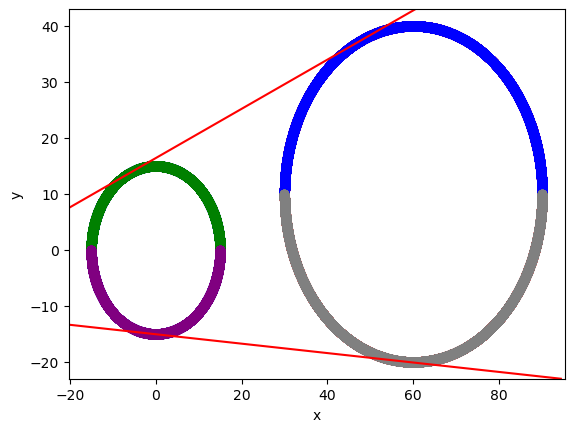

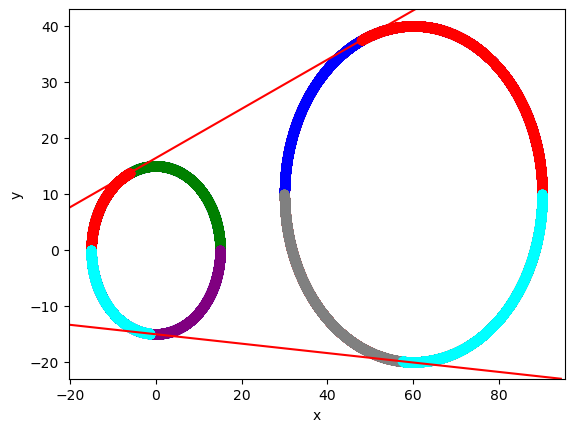

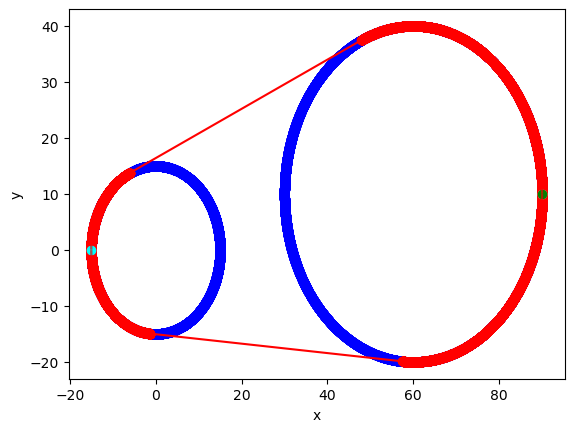

In [309]:
cipa1 = upper_circle_points((0, 0), 15, 10**4, 1, 6)
cipa2 = upper_circle_points((60, 10), 30, 10**4, 1, 6)
cipa1.sort()
cipa2.sort()
print("PIZDA NAD GLOWA")
vis6 = Visualizer()
vis6.add_point(cipa1, color = "blue")
vis6.add_point(cipa2, color = "red")
vis6.show()
cipa1_up, cipa1_down = classify(cipa1)
cipa2_up, cipa2_down = classify(cipa2)
vis6.add_point(cipa1_up, color = "green")
vis6.add_point(cipa1_down, color = "purple")
vis6.add_point(cipa2_up, color = "blue")
vis6.add_point(cipa2_down, color = "grey")
vis6.show()
x_up, y_up = bin_search(cipa1_up, cipa2_up)
vis6.add_line([(cipa1_up[x_up], cipa2_up[y_up])], color = "red")
vis6.show()
x_down, y_down = bin_search(cipa1_down, cipa2_down, -1)
vis6.add_line([(cipa1_down[x_down], cipa2_down[y_down])], color = "red")
vis6.show()
convex_up = merge(cipa1_up, cipa2_up, x_up, y_up)
convex_down = merge(cipa1_down, cipa2_down, x_down, y_down)
vis6.add_point(convex_up, color = "red")
vis6.add_point(convex_down, color = "cyan")
vis6.show()

vis7 = Visualizer()
convex_total = concat_arr(convex_up, convex_down)
vis7.add_point(cipa1, color = "blue")
vis7.add_point(cipa2, color = "blue")
vis7.add_point(convex_total, color = "red")
add_perimeter(convex_total, vis7, "red")
vis7.add_point([convex_up[0]], color = "cyan")
vis7.add_point([convex_down[-1]], color = "pink")
size = len(convex_total)
maxi = (-float('inf'), -float('inf'))
for i in range(1, size, 1):
    if(convex_total[i-1] > convex_total[i]):
        maxi = convex_total[i-1]
        break
vis7.add_point([maxi], color = "green")
vis7.show()